In [ ]:
# pip install pandas numpy scikit-learn matplotlib tensorflow

In [1]:
import pandas as pd
import numpy as np
import IPython
import IPython.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Conv1D, Flatten, Attention
from tensorflow.keras.layers import LayerNormalization, BatchNormalization, MultiHeadAttention, GlobalAveragePooling1D, Add
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint

In [2]:
# 1. Load the dataset
data = pd.read_csv('./data/BrentOilPricesMerged.csv')

In [3]:
# 2. Preprocess the data
# Convert Date to datetime format
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [4]:
data.head()

Price  neg_oil  neu_oil  pos_oil  compound_oil  neg_war  \
Date                                                                      
2023-04-03  84.930000    0.000    0.000    0.000        0.0000    0.000   
2023-04-04  84.940002    0.000    0.000    0.000        0.0000    0.000   
2023-04-05  84.989998    0.000    0.000    0.000        0.0000    0.000   
2023-04-06  85.120003    0.000    0.000    0.000        0.0000    0.000   
2023-04-10  84.180000    0.086    0.816    0.098        0.9796    0.144   

            neu_war  pos_war  compound_war  
Date                                        
2023-04-03    0.000    0.000        0.0000  
2023-04-04    0.000    0.000        0.0000  
2023-04-05    0.000    0.000        0.0000  
2023-04-06    0.776    0.224        0.9866  
2023-04-10    0.708    0.147       -0.1356

In [5]:
data.describe().transpose()

count       mean       std        min        25%        50%  \
Price         271.0  82.667343  5.567707  71.839996  78.139999  82.739998   
neg_oil       271.0   0.023033  0.024112   0.000000   0.000000   0.017500   
neu_oil       271.0   0.496814  0.361231   0.000000   0.000000   0.604750   
pos_oil       271.0   0.064340  0.055087   0.000000   0.000000   0.062000   
compound_oil  271.0   0.378112  0.429797  -0.955900   0.000000   0.270900   
neg_war       271.0   0.082097  0.071262   0.000000   0.013000   0.073000   
neu_war       271.0   0.802173  0.128576   0.000000   0.773586   0.817200   
pos_war       271.0   0.104691  0.065619   0.000000   0.066000   0.118000   
compound_war  271.0   0.163507  0.595739  -0.999900  -0.357750   0.115525   

                    75%        max  
Price         86.355000  96.550003  
neg_oil        0.038271   0.116000  
neu_oil        0.831000   0.960000  
pos_oil        0.100667   0.181000  
compound_oil   0.950900   0.999900  
neg_war        0.132375   0.272500  
neu_war        0.854250   1.000000  
pos_war        0.139875   0.435000  
compound_war   0.701659   0.986600

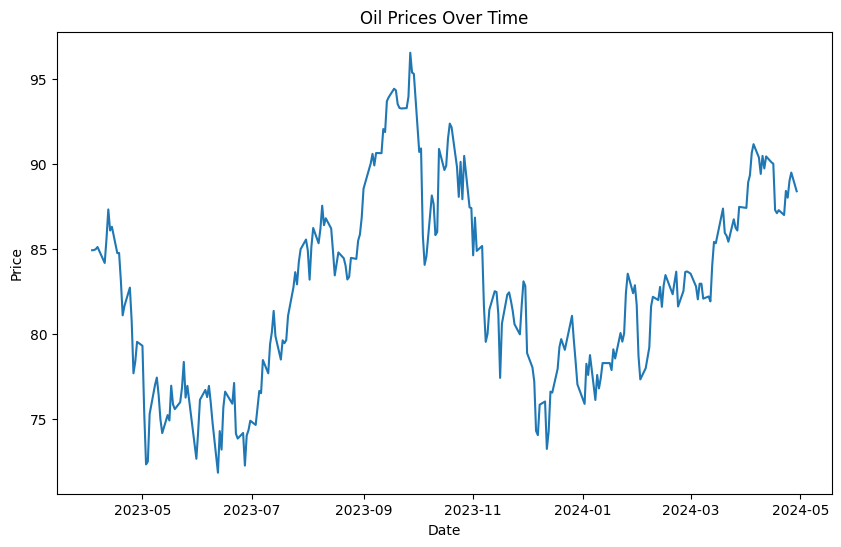

In [6]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data['Price'])
plt.title('Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [7]:
column_indices = {name: i for i, name in enumerate(data.columns)}
column_indices

{'Price': 0,
 'neg_oil': 1,
 'neu_oil': 2,
 'pos_oil': 3,
 'compound_oil': 4,
 'neg_war': 5,
 'neu_war': 6,
 'pos_war': 7,
 'compound_war': 8}

In [8]:
# Extract the relevant columns for oil sentiment data
# oil_data = data[['Price', 'neg_oil', 'neu_oil', 'pos_oil', 'compound_oil', 'neg_war', 'neu_war', 'pos_war', 'compound_war']]
# oil_data = data[['Price']]
oil_data = data[['Price', 'neg_oil', 'neu_oil', 'pos_oil', 'compound_oil']]
oil_data.head()

Price  neg_oil  neu_oil  pos_oil  compound_oil
Date                                                          
2023-04-03  84.930000    0.000    0.000    0.000        0.0000
2023-04-04  84.940002    0.000    0.000    0.000        0.0000
2023-04-05  84.989998    0.000    0.000    0.000        0.0000
2023-04-06  85.120003    0.000    0.000    0.000        0.0000
2023-04-10  84.180000    0.086    0.816    0.098        0.9796

In [9]:
# Normalize the price data
scaler = MinMaxScaler(feature_range=(0, 1))
oil_data['Price'] = scaler.fit_transform(oil_data['Price'].values.reshape(-1, 1))
# oil_data = scaler.fit_transform(oil_data)

C:\Users\wgras\AppData\Local\Temp\ipykernel_18240\1558082071.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oil_data['Price'] = scaler.fit_transform(oil_data['Price'].values.reshape(-1, 1))


In [10]:
n = len(oil_data)
train_df = oil_data[0:int(n*0.7)]
val_df = oil_data[int(n*0.7):int(n*0.875)]
test_df = oil_data[int(n*0.875):]

In [12]:
# train = 70%
# validation = 17.5%
# test - 12.5%

In [11]:
test_df

Price   neg_oil   neu_oil   pos_oil  compound_oil
Date                                                            
2024-03-12  0.407932  0.037667  0.400333  0.062000      0.188300
2024-03-13  0.493323  0.000000  0.575333  0.091333      0.493300
2024-03-14  0.549575  0.083200  0.843600  0.073200      0.005620
2024-03-15  0.546337  0.046500  0.710000  0.077333      0.266667
2024-03-18  0.609065  0.044000  0.399667  0.056500      0.277767
2024-03-19  0.628895  0.022714  0.751714  0.082714      0.442286
2024-03-20  0.571024  0.011250  0.686250  0.052500      0.431050
2024-03-21  0.564144  0.049000  0.582000  0.069000      0.177520
2024-03-22  0.549980  0.038000  0.595714  0.080571      0.357286
2024-03-25  0.603399  0.038400  0.696000  0.065600      0.116920
2024-03-26  0.583165  0.057500  0.412500  0.030000     -0.495150
2024-03-27  0.576689  0.003600  0.889200  0.107200      0.618920
2024-03-28  0.632942  0.017400  0.526000  0.056800      0.421760
2024-04-01  0.630514  0.021429  0.791714  0.043857      0.348143
2024-04-02  0.691218  0.068444  0.652222  0.057111     -0.061833
2024-04-03  0.708620  0.030000  0.675200  0.094800      0.295100
2024-04-04  0.761230  0.013667  0.404556  0.137222      0.242744
2024-04-05  0.782274  0.033000  0.630857  0.050429      0.274771
2024-04-08  0.750303  0.043333  0.830000  0.127333      0.434067
2024-04-09  0.711453  0.063400  0.648800  0.087800     -0.135040
2024-04-10  0.754351  0.044300  0.688900  0.066800      0.164840
2024-04-11  0.724403  0.052300  0.859900  0.087600      0.312020
2024-04-12  0.753136  0.011462  0.523692  0.080154      0.442392
2024-04-15  0.738972  0.048294  0.548941  0.049882     -0.064118
2024-04-16  0.735734  0.054889  0.846000  0.099333      0.245078
2024-04-17  0.625253  0.030769  0.596538  0.064923      0.155438
2024-04-18  0.617968  0.027111  0.517111  0.122333      0.258900
2024-04-19  0.625253  0.065500  0.818500  0.116000      0.496325
2024-04-22  0.613517  0.052083  0.686000  0.095083      0.521367
2024-04-23  0.670983  0.015700  0.639700  0.144500      0.635640
2024-04-24  0.654795  0.017944  0.444833  0.092833      0.363672
2024-04-25  0.694860  0.033182  0.746091  0.129818      0.486564
2024-04-26  0.714690  0.014200  0.659800  0.126000      0.596060
2024-04-29  0.670174  0.026900  0.691700  0.081500      0.444140

In [12]:
len(train_df),len(val_df),len(test_df)

(189, 48, 34)

In [13]:
train_df.columns

Index(['Price', 'neg_oil', 'neu_oil', 'pos_oil', 'compound_oil'], dtype='object')

In [14]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [15]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [16]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=1,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [17]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def all_data(self):
  return self.make_dataset(oil_data)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.all_data = all_data
WindowGenerator.example = example

In [18]:
val_performance = {}
performance = {}
histories={}
models_list={}
windows_list={}

windows_dictionary = {
    'weekly': 7, 
    'bi-weekly': 14, 
    'monthly': 30,       
}


In [19]:
for w in windows_dictionary:
    input_width=windows_dictionary[w]
    window = WindowGenerator(
        input_width=input_width, label_width=1, shift=1,
        label_columns=['Price']
    )
    windows_list[w]=window

In [20]:
windows_list

{'weekly': Total window size: 8
 Input indices: [0 1 2 3 4 5 6]
 Label indices: [7]
 Label column name(s): ['Price'],
 'bi-weekly': Total window size: 15
 Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 Label indices: [14]
 Label column name(s): ['Price'],
 'monthly': Total window size: 31
 Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29]
 Label indices: [30]
 Label column name(s): ['Price']}

In [21]:
windows_list['monthly']

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['Price']

In [22]:
MAX_EPOCHS = 100

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)

def compile_and_fit(model, window, patience=4):
  model.compile(
    # loss='mean_absolute_percentage_error',
    loss= tf.keras.losses.MeanSquaredError(),
    optimizer='adam',
    metrics=[
      tf.keras.metrics.MeanAbsolutePercentageError(),
      # tf.keras.metrics.MeanSquaredError()
      tf.keras.metrics.MeanAbsoluteError(),
    ]
  )

  history = model.fit(
    window.train, 
    epochs=MAX_EPOCHS, 
    validation_data=window.val,
    callbacks=[early_stopping,reduce_lr]
  )

  return history

1. Linear model

In [23]:
train_df.shape

(189, 5)

In [24]:
window=windows_list['monthly']
seq_length=30
input_shape=(seq_length, train_df.shape[1])
window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['Price']

In [25]:
input_shape

(30, 5)

In [26]:
# linear = tf.keras.Sequential([
#     tf.keras.layers.Dense(units=1, input_shape=input_shape)
# ])

def get_lstm_model_1(input_shape):
    # 3. Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    return model
# linear=get_ensemble_model2(input_shape)
model=get_lstm_model_1(input_shape)
# model=get_transformer_model(input_shape)

In [27]:
history = compile_and_fit(model, window)

histories_Linear = history
val_performance_Linear = model.evaluate(window.val, return_dict=True)
performance_Linear = model.evaluate(window.test, verbose=1, return_dict=True)

Epoch 1/100
159/159 [==============================] - 9s 25ms/step - loss: 0.0308 - mean_absolute_percentage_error: 987686.3125 - mean_absolute_error: 0.1372 - val_loss: 0.0580 - val_mean_absolute_percentage_error: 53.6900 - val_mean_absolute_error: 0.2392 - lr: 0.0010
Epoch 2/100
159/159 [==============================] - 3s 19ms/step - loss: 0.0255 - mean_absolute_percentage_error: 1190943.6250 - mean_absolute_error: 0.1306 - val_loss: 0.0456 - val_mean_absolute_percentage_error: 47.4771 - val_mean_absolute_error: 0.2118 - lr: 0.0010
Epoch 3/100
159/159 [==============================] - 3s 19ms/step - loss: 0.0256 - mean_absolute_percentage_error: 1268689.7500 - mean_absolute_error: 0.1277 - val_loss: 0.0278 - val_mean_absolute_percentage_error: 36.7496 - val_mean_absolute_error: 0.1644 - lr: 0.0010
Epoch 4/100
159/159 [==============================] - 3s 20ms/step - loss: 0.0232 - mean_absolute_percentage_error: 870074.1875 - mean_absolute_error: 0.1201 - val_loss: 0.0299 - val_m

In [28]:
histories_Linear.history.keys()

dict_keys(['loss', 'mean_absolute_percentage_error', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_percentage_error', 'val_mean_absolute_error', 'lr'])

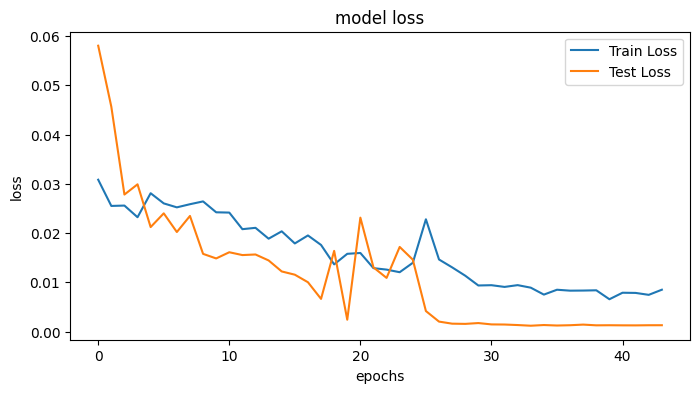

In [29]:
# Plot Train vs Test Loss
plt.figure(figsize=(8,4))
plt.plot(histories_Linear.history['loss'], label='Train Loss')
plt.plot(histories_Linear.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
# plt.savefig('outputs/reddit oil + war - lstm model 01 model loss.png')
plt.show()

In [30]:
all_predict = model.predict(window.all_data)
all_predict

241/241 [==============================] - 2s 5ms/step


array([[0.17889328],
       [0.16972408],
       [0.17236726],
       [0.17075114],
       [0.16592526],
       [0.16480763],
       [0.16818744],
       [0.18553078],
       [0.19159465],
       [0.19688004],
       [0.1835722 ],
       [0.16407515],
       [0.1551624 ],
       [0.16060054],
       [0.1718111 ],
       [0.17999522],
       [0.18914175],
       [0.19211654],
       [0.18004207],
       [0.15205002],
       [0.13724971],
       [0.12366774],
       [0.12553644],
       [0.12505868],
       [0.1263027 ],
       [0.13745087],
       [0.1256374 ],
       [0.1077839 ],
       [0.09637897],
       [0.07429418],
       [0.07119785],
       [0.09193161],
       [0.11582243],
       [0.12756862],
       [0.15899774],
       [0.1910071 ],
       [0.23766202],
       [0.2737754 ],
       [0.31892154],
       [0.3416853 ],
       [0.3664891 ],
       [0.37951025],
       [0.38141292],
       [0.38728645],
       [0.39194304],
       [0.3965957 ],
       [0.40759927],
       [0.425

In [31]:
all_predict.shape

(241, 1)

In [32]:
X_all_data = scaler.inverse_transform(all_predict)
# Y_test = np.array([s[1][0][0][0].numpy() for s in iter(window.test)])
Y_all_data = oil_data['Price'].values
Y_all_data = scaler.inverse_transform(Y_all_data.reshape(-1, 1))

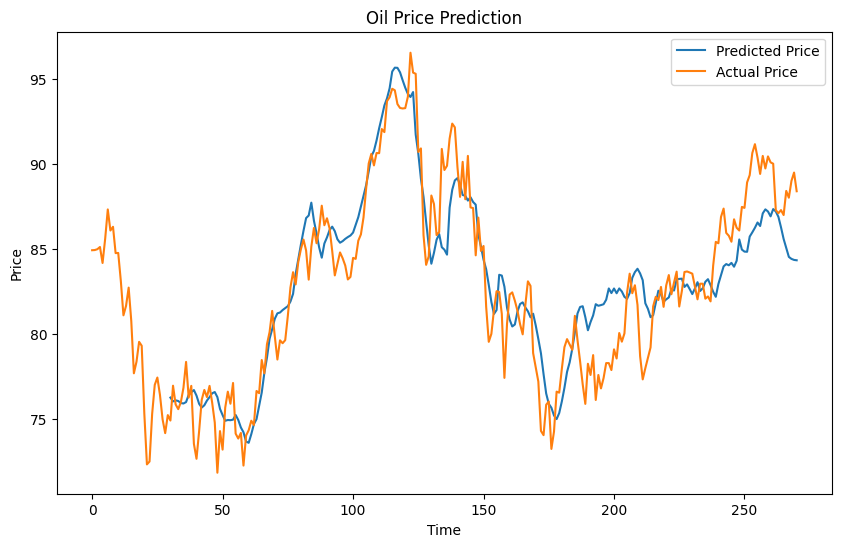

In [33]:
# Plot predictions vs actual values
seq_length = 30

plt.figure(figsize=(10, 6))

plt.plot(range(seq_length, seq_length + len(X_all_data)), X_all_data, label='Predicted Price')
plt.plot(range(len(Y_all_data)), Y_all_data, label='Actual Price')
plt.title('Oil Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
# plt.savefig('outputs/lstm model 01 Oil Price Prediction.png')
plt.show()

In [34]:

def get_lstm_model_1(input_shape):
    # 3. Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    return model

In [35]:

def get_lstm_model_2(input_shape):
    model = Sequential()
    model.add(LSTM(units=60, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.1))
    model.add(LSTM(units=60, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=60, return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(units=1))

    return model

In [36]:

def get_lstm_model_3(input_shape):
    input = keras.Input(shape=input_shape)

    layer = LSTM(units=60, return_sequences=True)(input)
    layer = Dropout(0.2)(layer)
    layer = LSTM(units=50, return_sequences=True)(layer)
    layer = Dropout(0.2)(layer)
    layer = LSTM(units=40, return_sequences=True)(layer)
    layer = Dropout(0.2)(layer)
    layer = LSTM(units=30, return_sequences=True)(layer)
    layer = Dropout(0.2)(layer)
    layer = LSTM(units=30, return_sequences=True)(layer)
    layer = Dropout(0.2)(layer)
    layer = LSTM(units=20, return_sequences=False)(layer)
    layer = Dropout(0.2)(layer)
    output = Dense(units=1)(layer)

    model=keras.Model(input, output)


    return model

In [37]:
def get_lstm_model_4(input_shape):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    return model

In [38]:
def get_lstm_model_5(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model

In [39]:

def get_bidirectional_lstm_model_1(input_shape):
    model = Sequential()
    model.add(LSTM(units=20, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.1))
    model.add(Bidirectional(LSTM(units=20, return_sequences=True)))
    model.add(Dropout(0.1))
    model.add(Bidirectional(LSTM(units=10, return_sequences=False)))
    model.add(Dropout(0.1))
    model.add(Dense(units=1))

    return model

In [40]:
def get_bidirectional_lstm_model_2(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(100, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(100, return_sequences=False)))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    return model

def get_bidirectional_lstm_model_3(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(50, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(50, return_sequences=False)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model

def get_bidirectional_lstm_model_4(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(50, return_sequences=False)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model

In [41]:
def get_stacked_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(1))
    return model

In [43]:
def get_attention_lstm_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    lstm_out = LSTM(50, return_sequences=True)(inputs)
    attention = Attention()([lstm_out, lstm_out])
    dense = Dense(1)(attention)
    model = tf.keras.Model(inputs=inputs, outputs=dense)
    return model

In [44]:
models_name_list={
    'lstm_model_1' : get_lstm_model_1 ,
    'lstm_model_2' : get_lstm_model_2 ,
    'lstm_model_3' : get_lstm_model_3 ,
    'lstm_model_4' : get_lstm_model_4 ,
    'lstm_model_4' : get_lstm_model_5 ,
    'bidirectional_lstm_model_1' : get_bidirectional_lstm_model_1 ,
    'bidirectional_lstm_model_2' : get_bidirectional_lstm_model_2 ,
    'bidirectional_lstm_model_3' : get_bidirectional_lstm_model_3 ,
    'bidirectional_lstm_model_4' : get_bidirectional_lstm_model_4 ,
    'stacked_lstm_model' : get_stacked_lstm_model ,
    'attention_lstm_model' : get_attention_lstm_model ,
}
models_list={}

In [45]:
for model_type in models_name_list:
    print(model_type)

lstm_model_1
lstm_model_2
lstm_model_3
lstm_model_4
bidirectional_lstm_model_1
bidirectional_lstm_model_2
bidirectional_lstm_model_3
bidirectional_lstm_model_4
stacked_lstm_model
attention_lstm_model


In [46]:
def create_model_for_each_model_type(model_type):
    for window_name in windows_dictionary:
        seq_length=windows_dictionary[window_name]
        window = windows_list[window_name]
        input_shape=(seq_length, train_df.shape[1])


        model_name=f'{model_type}_{window_name}'
        print('\n\n\n--------------',model_name, input_shape, '--------------')
        model = models_name_list[model_type](input_shape)
        print(model.summary())
        
        models_list[model_name]= {
            'model':model,
            'window':window,
            'seq_length':seq_length

        }


In [47]:
for model_type in models_name_list:
    print('\n------------',model_type,'------------')
    create_model_for_each_model_type(model_type)


------------ lstm_model_1 ------------



-------------- lstm_model_1_weekly (7, 5) --------------
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 7, 50)             11200     
                                                                 
 dropout_2 (Dropout)         (None, 7, 50)             0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 31451 (122.86 KB)
Trainable params: 31451 (122.86 KB)
Non-trainable para

In [48]:
models_list

{'lstm_model_1_weekly': {'model': <keras.src.engine.sequential.Sequential at 0x132a4102490>,
  'window': Total window size: 8
  Input indices: [0 1 2 3 4 5 6]
  Label indices: [7]
  Label column name(s): ['Price'],
  'seq_length': 7},
 'lstm_model_1_bi-weekly': {'model': <keras.src.engine.sequential.Sequential at 0x132a5af2190>,
  'window': Total window size: 15
  Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
  Label indices: [14]
  Label column name(s): ['Price'],
  'seq_length': 14},
 'lstm_model_1_monthly': {'model': <keras.src.engine.sequential.Sequential at 0x132a5b6e010>,
  'window': Total window size: 31
  Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
   24 25 26 27 28 29]
  Label indices: [30]
  Label column name(s): ['Price'],
  'seq_length': 30},
 'lstm_model_2_weekly': {'model': <keras.src.engine.sequential.Sequential at 0x132a5c9a490>,
  'window': Total window size: 8
  Input indices: [0 1 2 3 4 5 6]
  Label indices: [7

In [49]:
len(models_list)

30

In [50]:
models_list['lstm_model_1_weekly']

{'model': <keras.src.engine.sequential.Sequential at 0x132a4102490>,
 'window': Total window size: 8
 Input indices: [0 1 2 3 4 5 6]
 Label indices: [7]
 Label column name(s): ['Price'],
 'seq_length': 7}

In [51]:
model_name='lstm_model_1_weekly' 
model = models_list[model_name]['model']
window = models_list[model_name]['window']
window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [7]
Label column name(s): ['Price']

In [52]:
for model_name in models_list:
    model = models_list[model_name]['model']
    window = models_list[model_name]['window']
    
    print('\n\n\n------------',model_name,'------------')
    history = compile_and_fit(model, window)

    histories[model_name] = history
    print('------------val performance')
    val_performance[model_name] = model.evaluate(window.val, return_dict=True)
    print('------------test performance')
    performance[model_name] = model.evaluate(window.test, verbose=1, return_dict=True)




------------ lstm_model_1_weekly ------------
Epoch 1/100
182/182 [==============================] - 6s 12ms/step - loss: 0.0245 - mean_absolute_percentage_error: 1031501.8125 - mean_absolute_error: 0.1203 - val_loss: 0.0294 - val_mean_absolute_percentage_error: 37.6753 - val_mean_absolute_error: 0.1549 - lr: 0.0010
Epoch 2/100
182/182 [==============================] - 1s 8ms/step - loss: 0.0271 - mean_absolute_percentage_error: 740398.0625 - mean_absolute_error: 0.1279 - val_loss: 0.0269 - val_mean_absolute_percentage_error: 35.2137 - val_mean_absolute_error: 0.1461 - lr: 0.0010
Epoch 3/100
182/182 [==============================] - 1s 7ms/step - loss: 0.0236 - mean_absolute_percentage_error: 831559.1250 - mean_absolute_error: 0.1227 - val_loss: 0.0202 - val_mean_absolute_percentage_error: 29.7231 - val_mean_absolute_error: 0.1243 - lr: 0.0010
Epoch 4/100
182/182 [==============================] - 2s 9ms/step - loss: 0.0233 - mean_absolute_percentage_error: 973310.0000 - mean_abso

## evaluate

In [53]:
histories

{'lstm_model_1_weekly': <keras.src.callbacks.History at 0x132a742fa50>,
 'lstm_model_1_bi-weekly': <keras.src.callbacks.History at 0x132a5ae8fd0>,
 'lstm_model_1_monthly': <keras.src.callbacks.History at 0x132b1552ad0>,
 'lstm_model_2_weekly': <keras.src.callbacks.History at 0x132b242df10>,
 'lstm_model_2_bi-weekly': <keras.src.callbacks.History at 0x132b56c5f10>,
 'lstm_model_2_monthly': <keras.src.callbacks.History at 0x132bc285f10>,
 'lstm_model_3_weekly': <keras.src.callbacks.History at 0x132c39f8fd0>,
 'lstm_model_3_bi-weekly': <keras.src.callbacks.History at 0x132cd6d5f10>,
 'lstm_model_3_monthly': <keras.src.callbacks.History at 0x132e40f4e50>,
 'lstm_model_4_weekly': <keras.src.callbacks.History at 0x132e406df10>,
 'lstm_model_4_bi-weekly': <keras.src.callbacks.History at 0x1330e029bd0>,
 'lstm_model_4_monthly': <keras.src.callbacks.History at 0x133148c8fd0>,
 'bidirectional_lstm_model_1_weekly': <keras.src.callbacks.History at 0x13315dddf10>,
 'bidirectional_lstm_model_1_bi-we

In [54]:
len(histories)

30

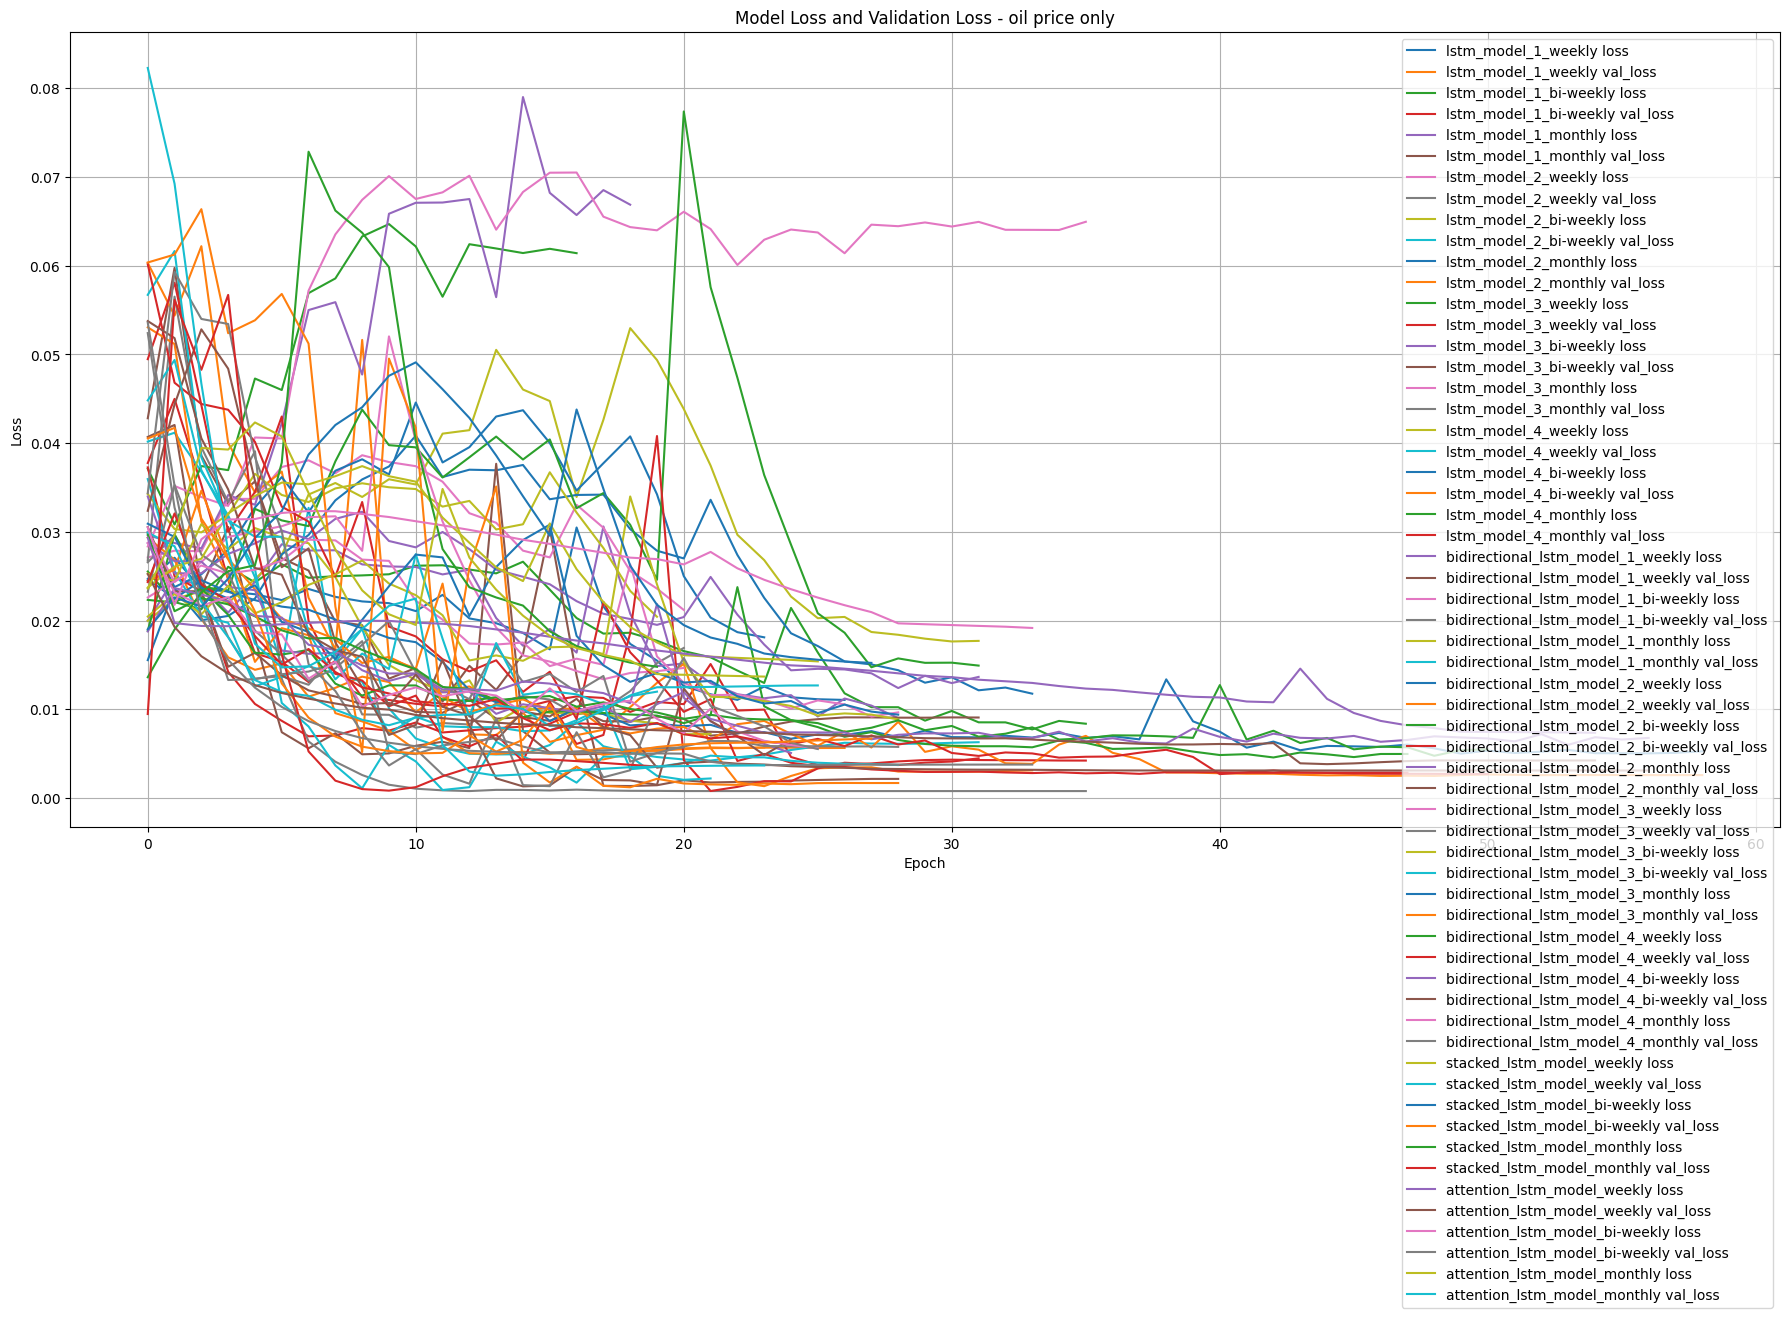

In [55]:
plt.figure(figsize=(18, 12))
for h in (histories):    # Plot Train vs Test Loss
    history=histories[h]
    plt.plot(history.history['loss'], label=f'{h} loss')
    plt.plot(history.history['val_loss'], label=f'{h} val_loss')

plt.title('Model Loss and Validation Loss - oil price only')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'outputs/oil_reddit_oil/LSTM model loss all models (oil price + reddit oil sentiments).png')

In [56]:
val_performance

{'lstm_model_1_weekly': {'loss': 0.004305223934352398,
  'mean_absolute_percentage_error': 15.533248901367188,
  'mean_absolute_error': 0.0535566508769989},
 'lstm_model_1_bi-weekly': {'loss': 0.003739958396181464,
  'mean_absolute_percentage_error': 12.781572341918945,
  'mean_absolute_error': 0.046844735741615295},
 'lstm_model_1_monthly': {'loss': 0.0013517431216314435,
  'mean_absolute_percentage_error': 7.101149559020996,
  'mean_absolute_error': 0.03110787272453308},
 'lstm_model_2_weekly': {'loss': 0.007932121865451336,
  'mean_absolute_percentage_error': 23.044504165649414,
  'mean_absolute_error': 0.08210577070713043},
 'lstm_model_2_bi-weekly': {'loss': 0.0042227185331285,
  'mean_absolute_percentage_error': 14.03296947479248,
  'mean_absolute_error': 0.05058006942272186},
 'lstm_model_2_monthly': {'loss': 0.0013361898018047214,
  'mean_absolute_percentage_error': 6.924994945526123,
  'mean_absolute_error': 0.03014240600168705},
 'lstm_model_3_weekly': {'loss': 0.006959374994

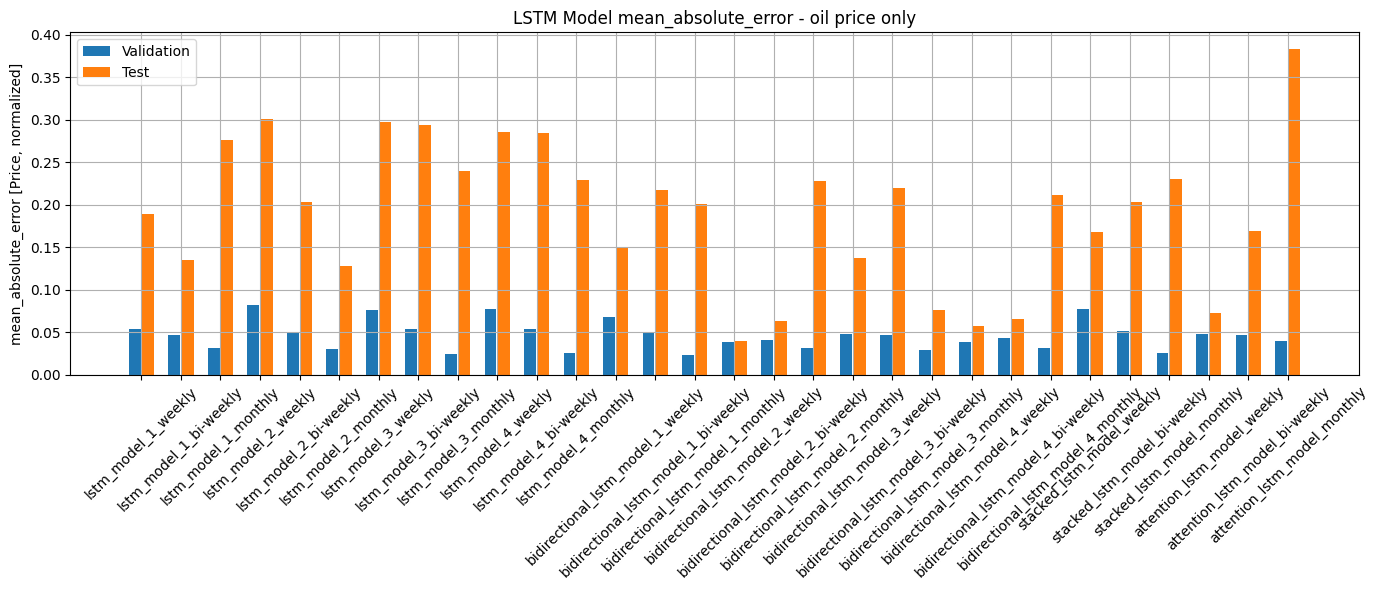

In [57]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.figure(figsize=(14, 6))
plt.title('LSTM Model mean_absolute_error - oil price only')
plt.ylabel('mean_absolute_error [Price, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig(f'outputs/oil_reddit_oil/LSTM mean_absolute_error all models (oil price + reddit oil sentiments).png')

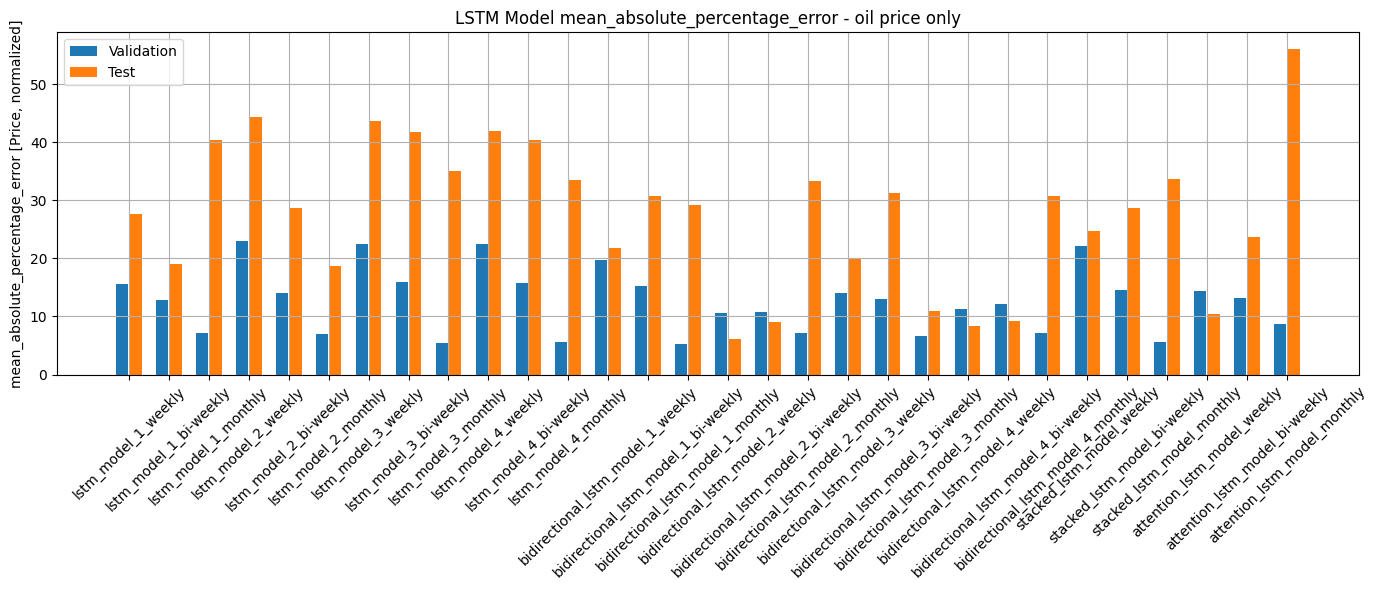

In [58]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_percentage_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]
plt.figure(figsize=(14, 6))
plt.title('LSTM Model mean_absolute_percentage_error - oil price only')
plt.ylabel('mean_absolute_percentage_error [Price, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig(f'outputs/oil_reddit_oil/LSTM mean_absolute_percentage_error all models (oil price + reddit oil sentiments).png')

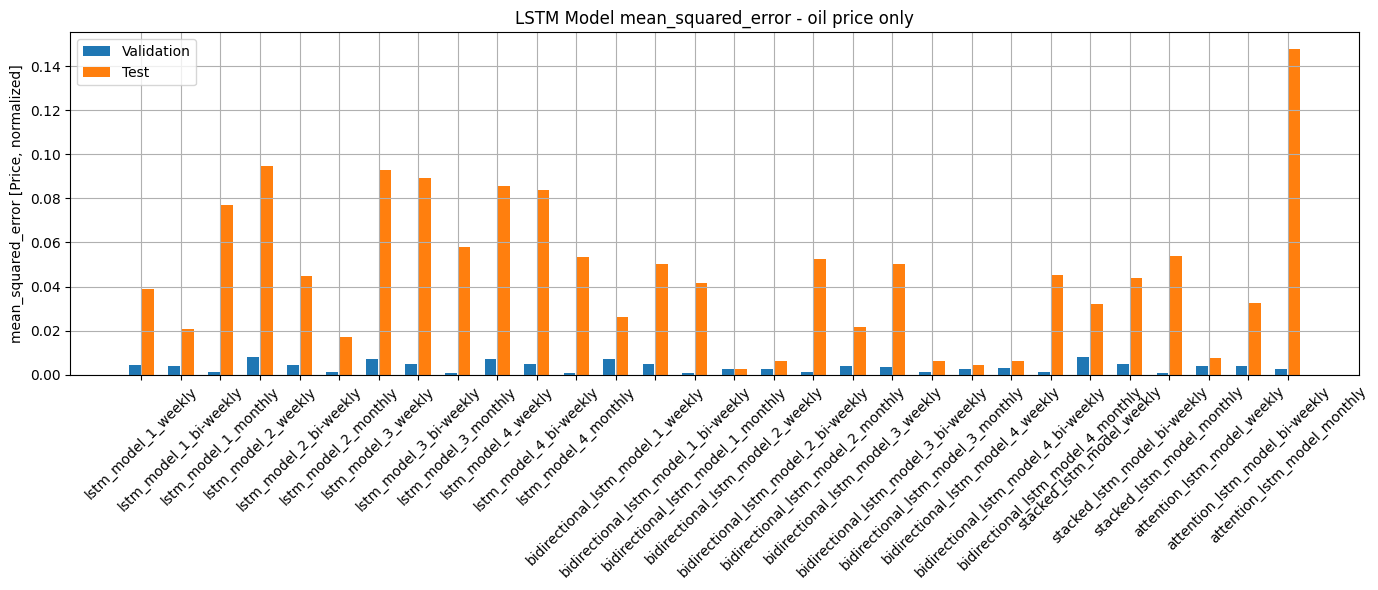

In [59]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_squared_error '
val_mae = [v['loss'] for v in val_performance.values()]
test_mae = [v['loss'] for v in performance.values()]
plt.figure(figsize=(14, 6))
plt.title('LSTM Model mean_squared_error - oil price only')
plt.ylabel('mean_squared_error [Price, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig(f'outputs/oil_reddit_oil/LSTM mean_squared_error all models (oil price + reddit oil sentiments).png')


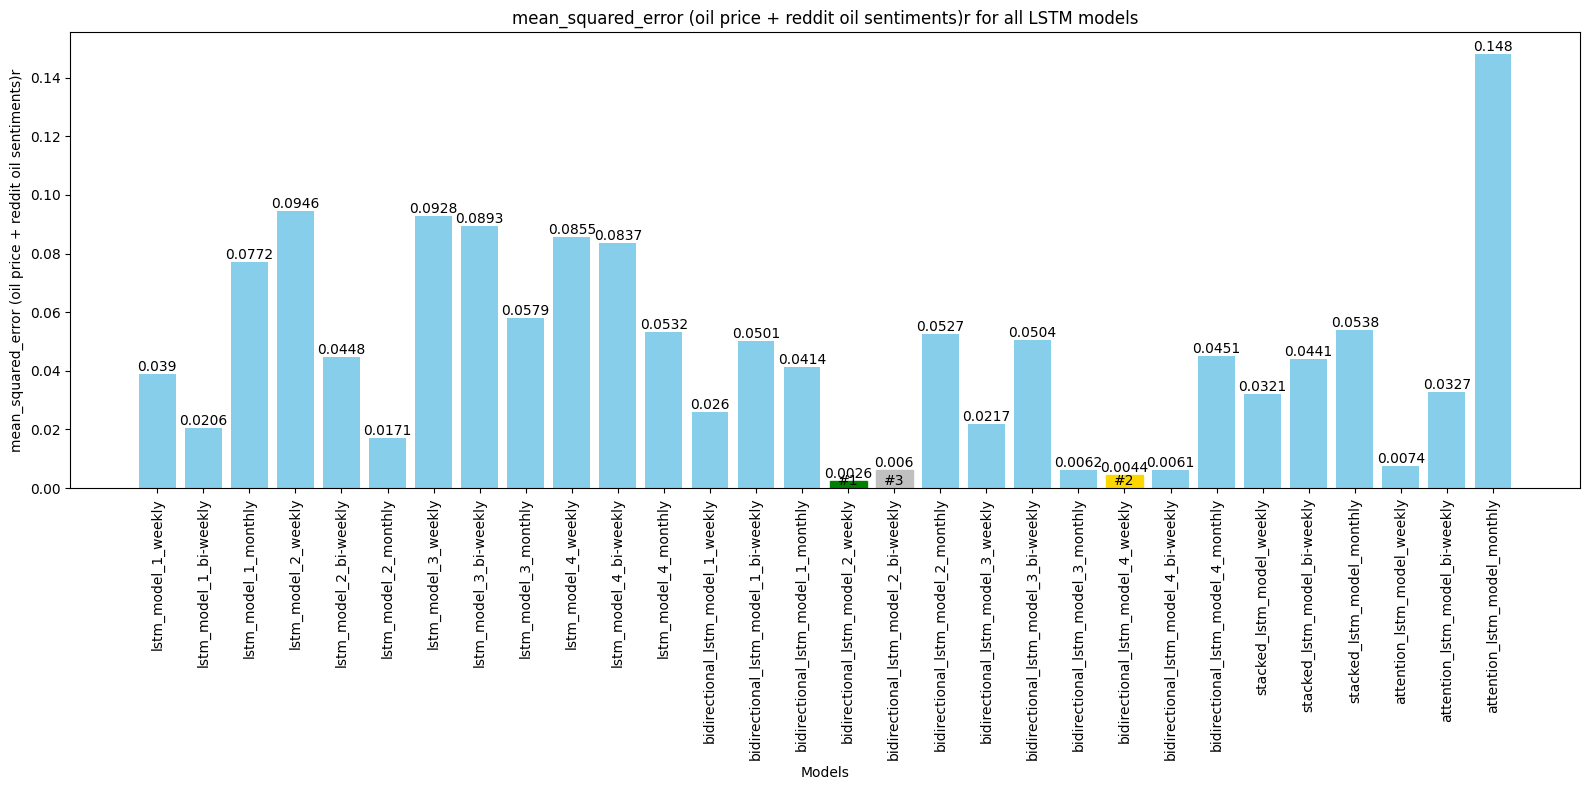

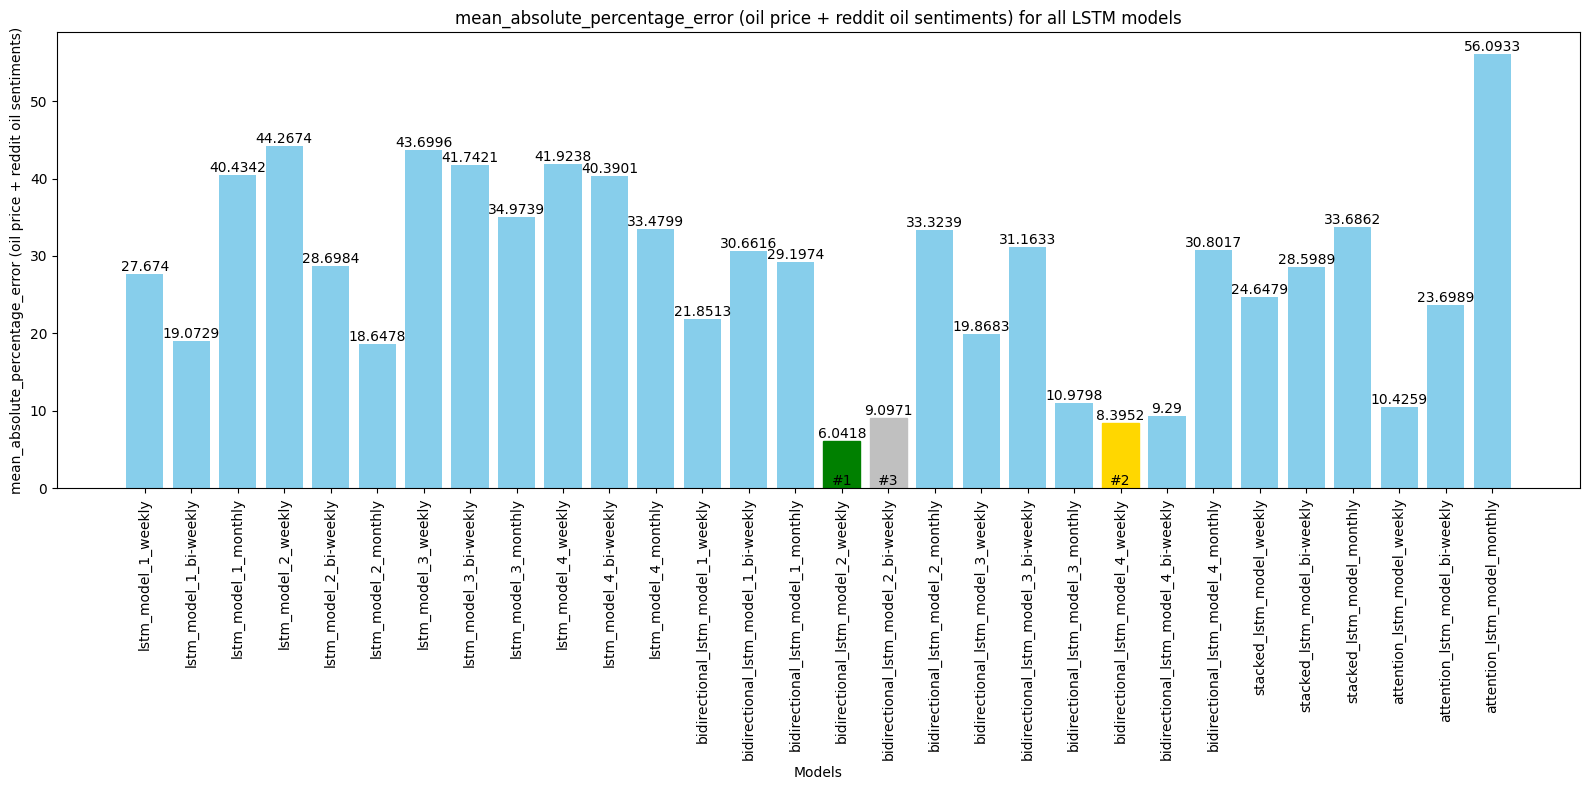

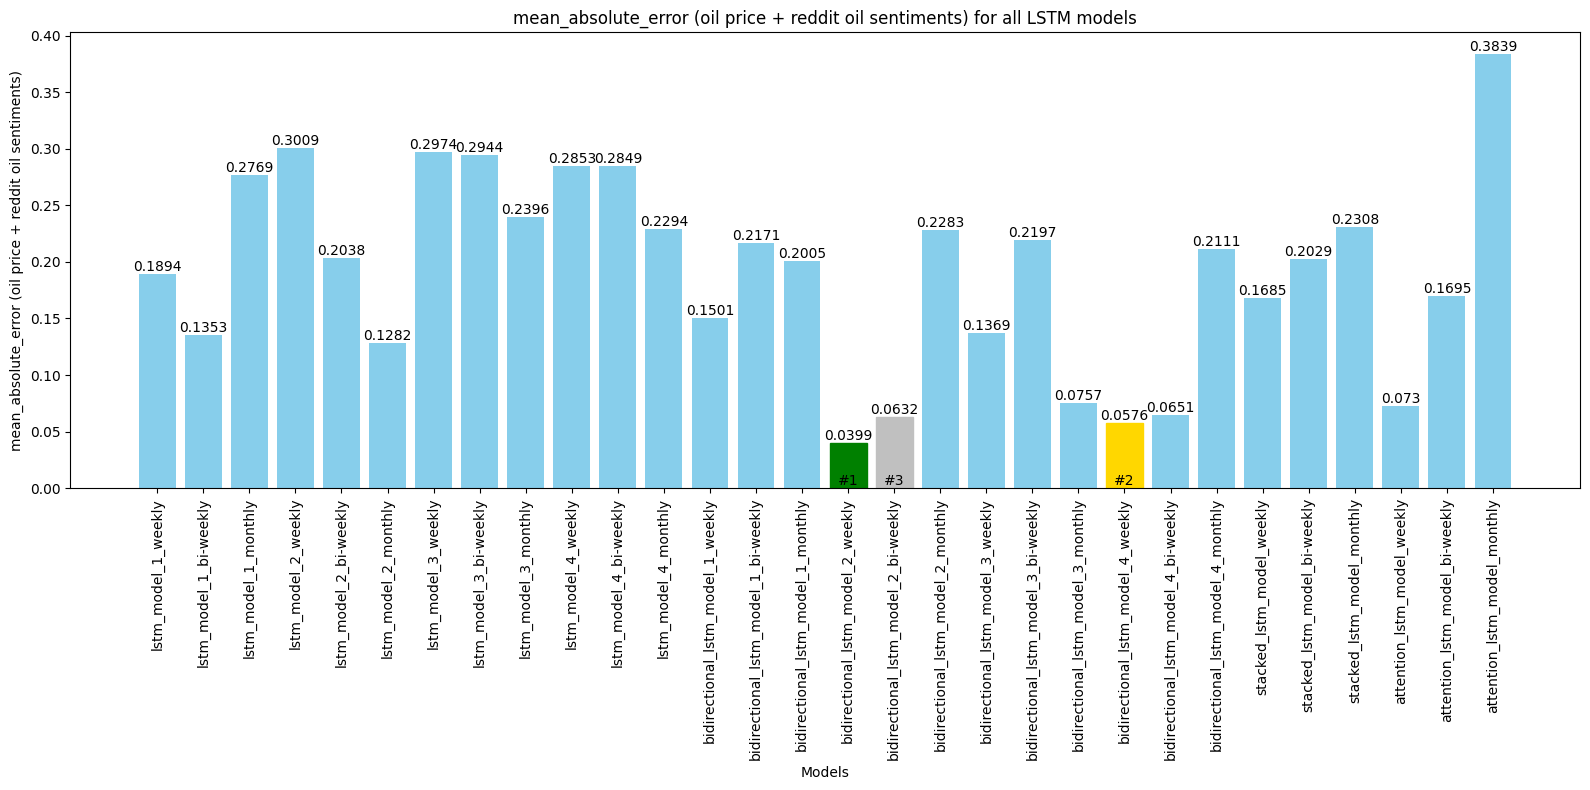

Top 3 models with minimum loss: ['bidirectional_lstm_model_2_weekly', 'bidirectional_lstm_model_4_weekly', 'bidirectional_lstm_model_2_bi-weekly']
Top 3 models with minimum mean_absolute_error: ['bidirectional_lstm_model_2_weekly', 'bidirectional_lstm_model_4_weekly', 'bidirectional_lstm_model_2_bi-weekly']
Top 3 models with minimum mean_squared_error: ['bidirectional_lstm_model_2_weekly', 'bidirectional_lstm_model_4_weekly', 'bidirectional_lstm_model_2_bi-weekly']


In [60]:
# Extract data for each metric
models = list(performance.keys())
loss_values = [performance[model]['loss'] for model in models]
mae_values = [performance[model]['mean_absolute_percentage_error'] for model in models]
mse_values = [performance[model]['mean_absolute_error'] for model in models]

# Function to plot and save a metric, highlighting the best model
def plot_and_save_metric(metric_values, metric_name, best_models_indices):
    plt.figure(figsize=(16, 8))
    bars = plt.bar(models, metric_values, color='skyblue')
    plt.xlabel('Models')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} for all LSTM models')
    plt.xticks(rotation=90)
    plt.tight_layout()

    # Highlight the best models with different colors
    colors = ['green', 'gold', 'silver']
    for rank, index in enumerate(best_models_indices):
        bars[index].set_color(colors[rank])
        yval = bars[index].get_height()

        plt.text(bars[index].get_x() + bars[index].get_width()/2,  0, f'#{rank+1}', ha='center', va='bottom')

    # Annotate all bars with their values
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

    plt.savefig(f'outputs/oil_reddit_oil/LSTM {metric_name}_comparison.png')
    plt.show()

# Find the indices of the top 3 models with the minimum values for each metric
top_n = 3

min_loss_indices = np.argsort(loss_values)[:top_n]
min_mae_indices = np.argsort(mae_values)[:top_n]
min_mse_indices = np.argsort(mse_values)[:top_n]
# Plot and save loss
plot_and_save_metric(loss_values, 'mean_squared_error (oil price + reddit oil sentiments)r', min_loss_indices)

# Plot and save mean_absolute_error
plot_and_save_metric(mae_values, 'mean_absolute_percentage_error (oil price + reddit oil sentiments)', min_mae_indices)

# Plot and save mean_squared_error
plot_and_save_metric(mse_values, 'mean_absolute_error (oil price + reddit oil sentiments)', min_mse_indices)

# Get the model names for the top 3 models
min_loss_models = [models[i] for i in min_loss_indices]
min_mae_models = [models[i] for i in min_mae_indices]
min_mse_models = [models[i] for i in min_mse_indices]

print(f'Top {top_n} models with minimum loss: {min_loss_models}')
print(f'Top {top_n} models with minimum mean_absolute_error: {min_mae_models}')
print(f'Top {top_n} models with minimum mean_squared_error: {min_mse_models}')

In [61]:
model_name='lstm_model_1_weekly' 
model = models_list[model_name]['model']
window = models_list[model_name]['window']
seq_length = models_list[model_name]['seq_length']

In [62]:
window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [7]
Label column name(s): ['Price']

In [63]:
seq_length

7

In [64]:
all_predict = model.predict(window.all_data)
print(all_predict.shape)

264/264 [==============================] - 2s 2ms/step
(264, 1)


In [65]:
all_predict[0]

array([0.43903655], dtype=float32)

264/264 [==============================] - 1s 2ms/step


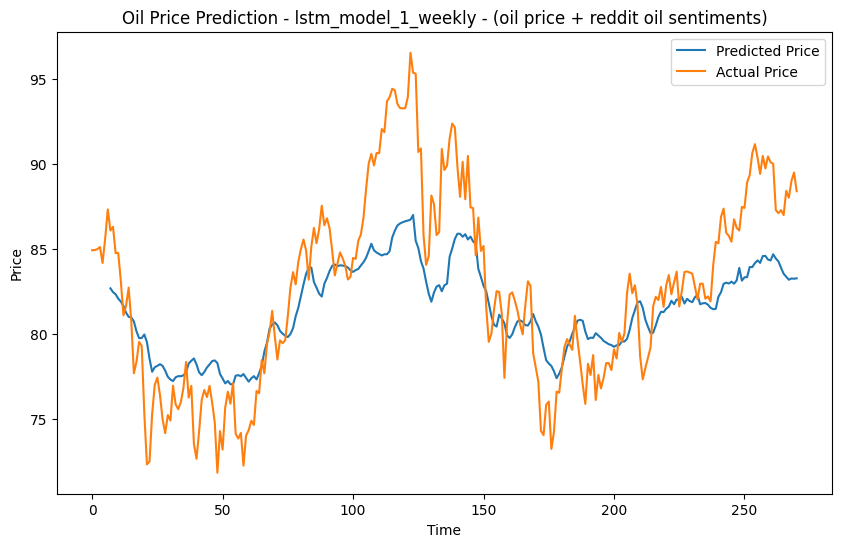

257/257 [==============================] - 2s 3ms/step


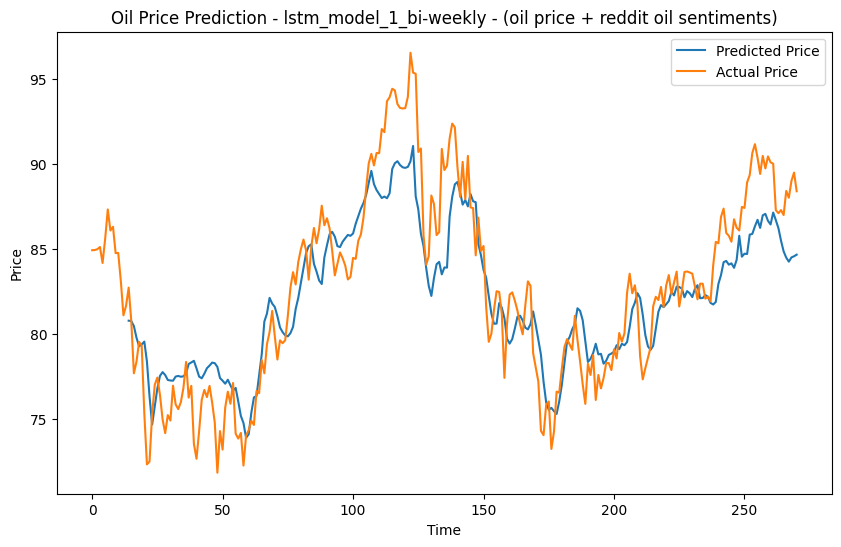

241/241 [==============================] - 2s 4ms/step


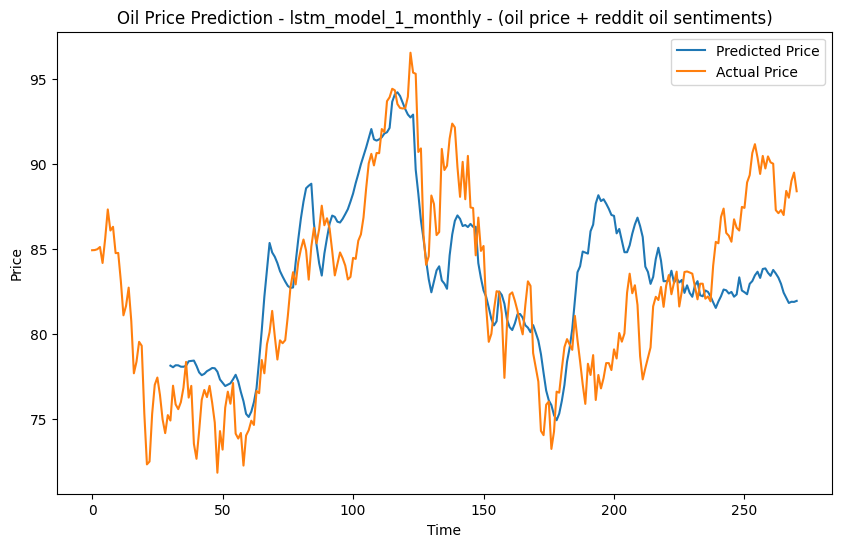

264/264 [==============================] - 2s 3ms/step


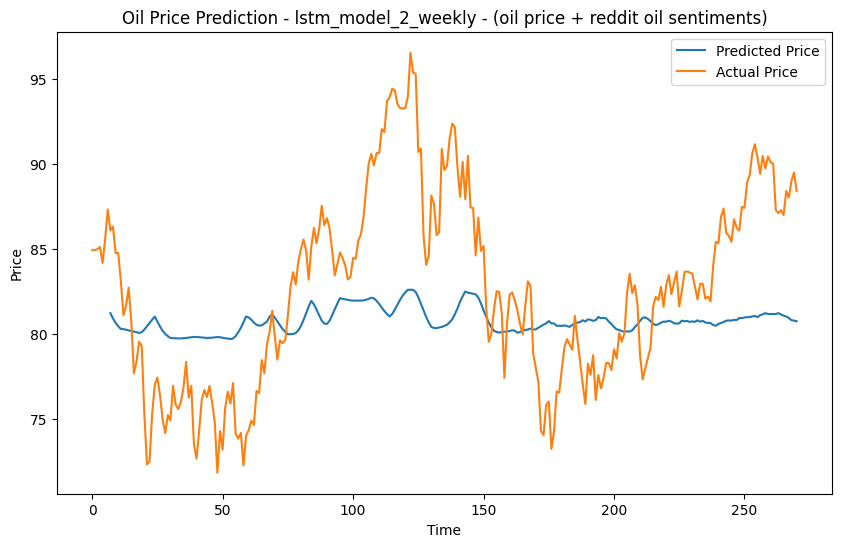

257/257 [==============================] - 2s 4ms/step


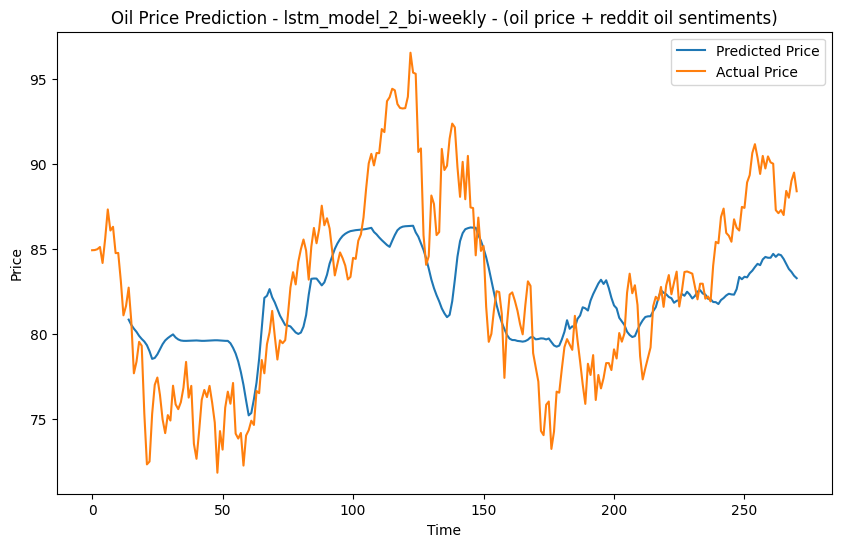

241/241 [==============================] - 3s 6ms/step


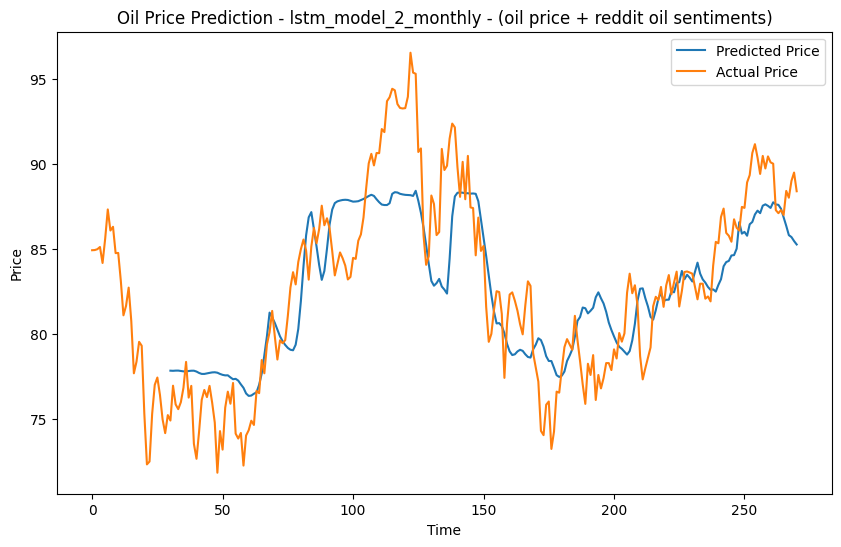

264/264 [==============================] - 4s 5ms/step


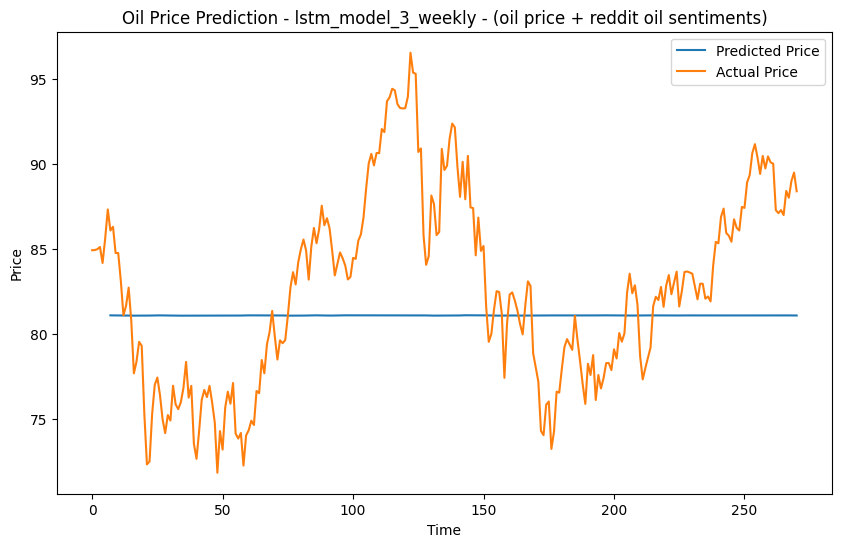

257/257 [==============================] - 5s 7ms/step


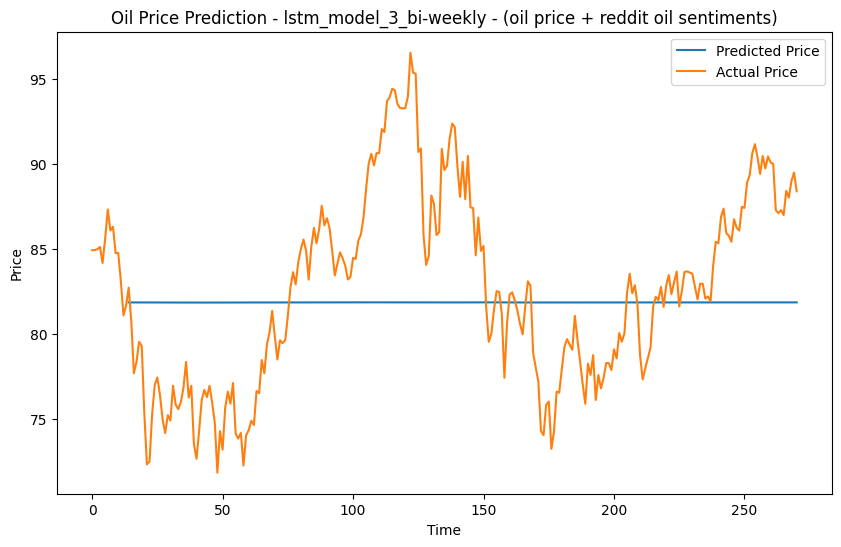

241/241 [==============================] - 10s 10ms/step


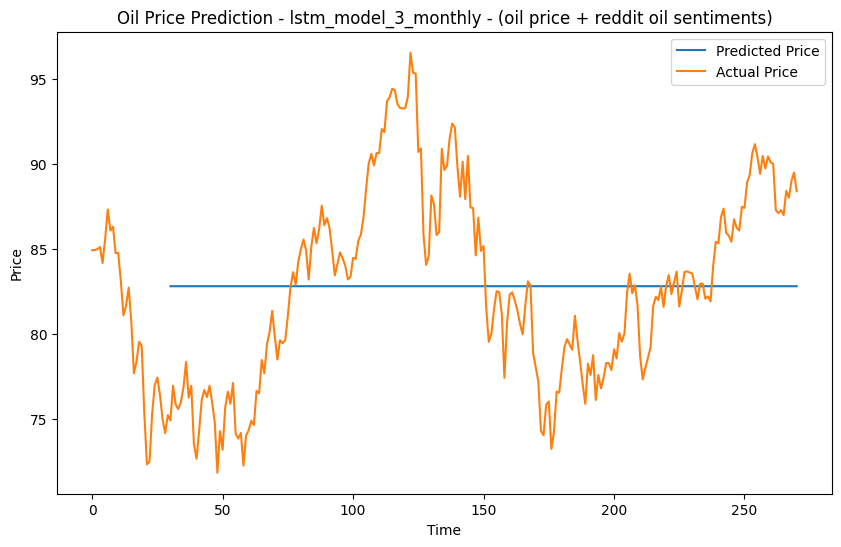

264/264 [==============================] - 2s 3ms/step


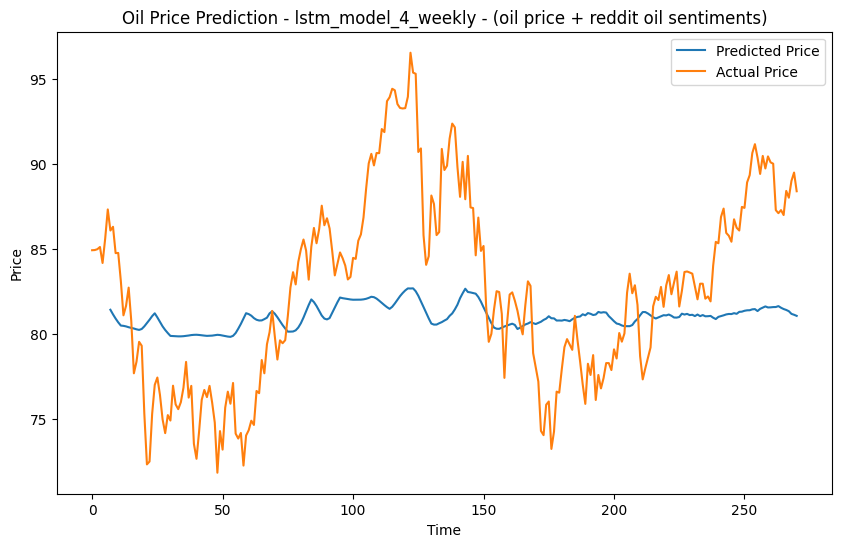

257/257 [==============================] - 2s 4ms/step


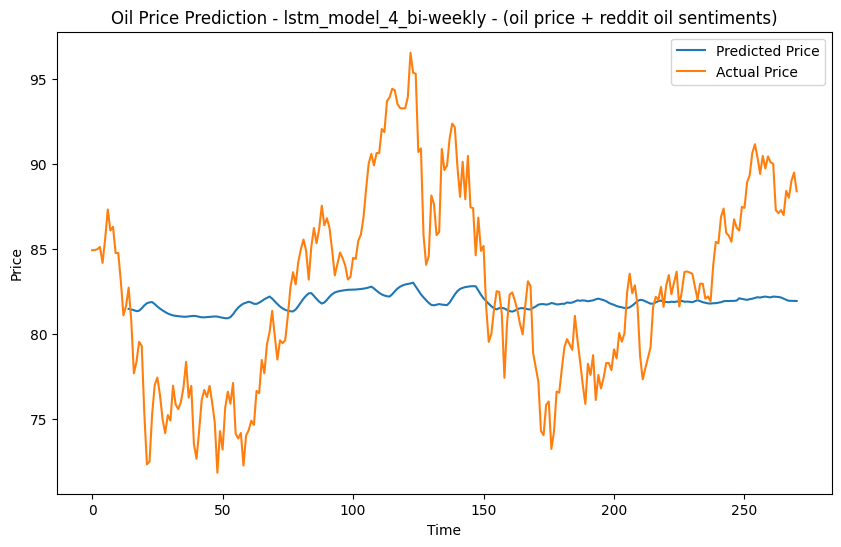

241/241 [==============================] - 3s 6ms/step


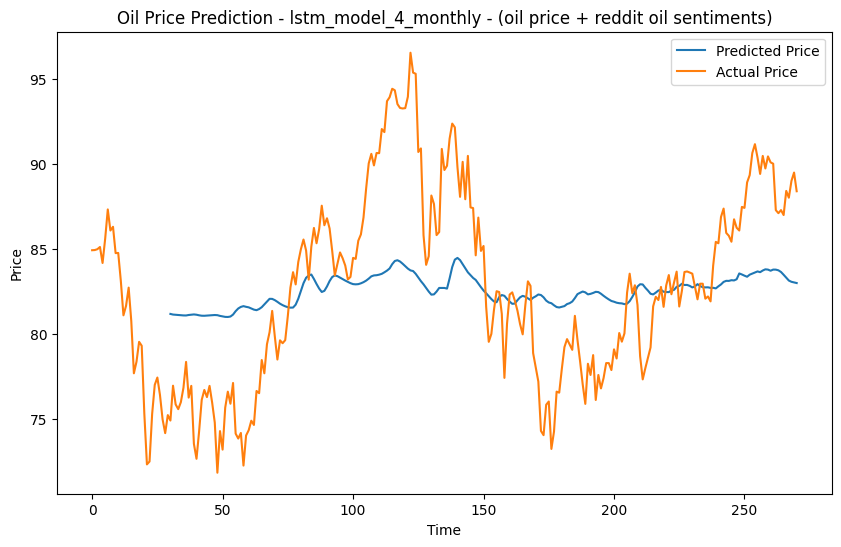

264/264 [==============================] - 3s 3ms/step


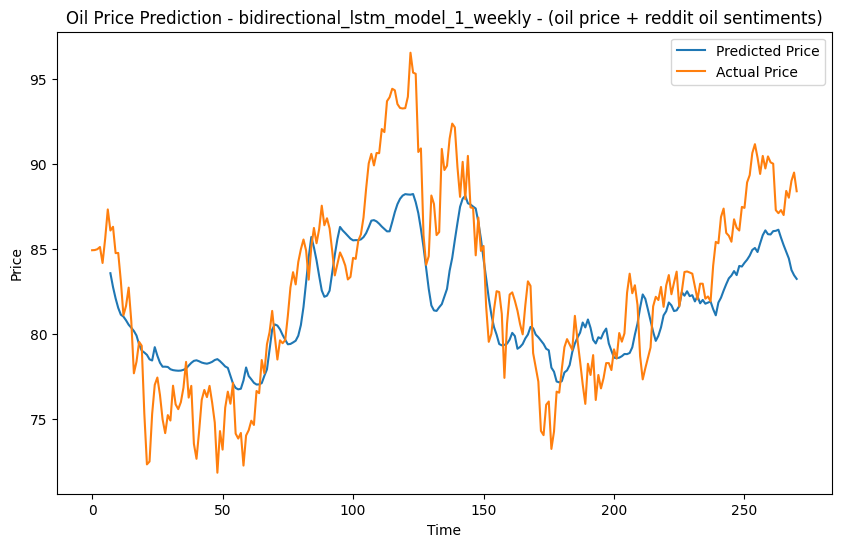

257/257 [==============================] - 3s 4ms/step


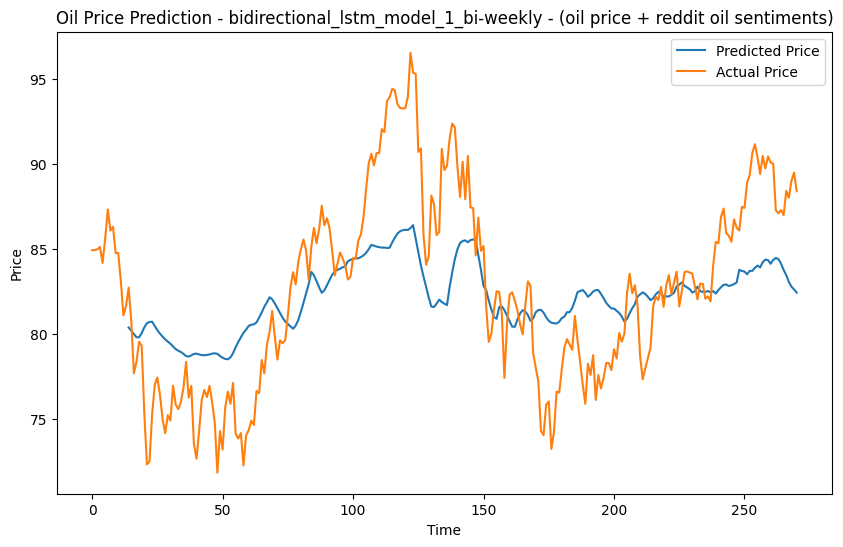

241/241 [==============================] - 4s 8ms/step


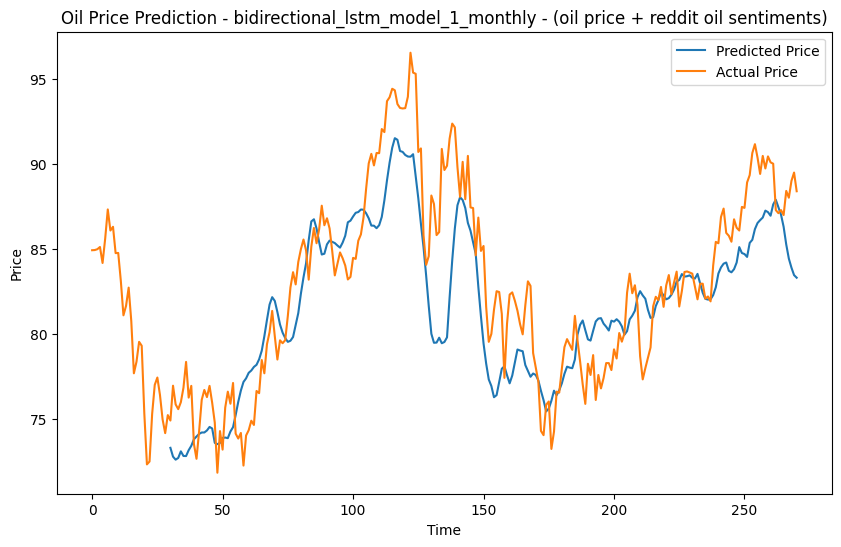

264/264 [==============================] - 2s 3ms/step


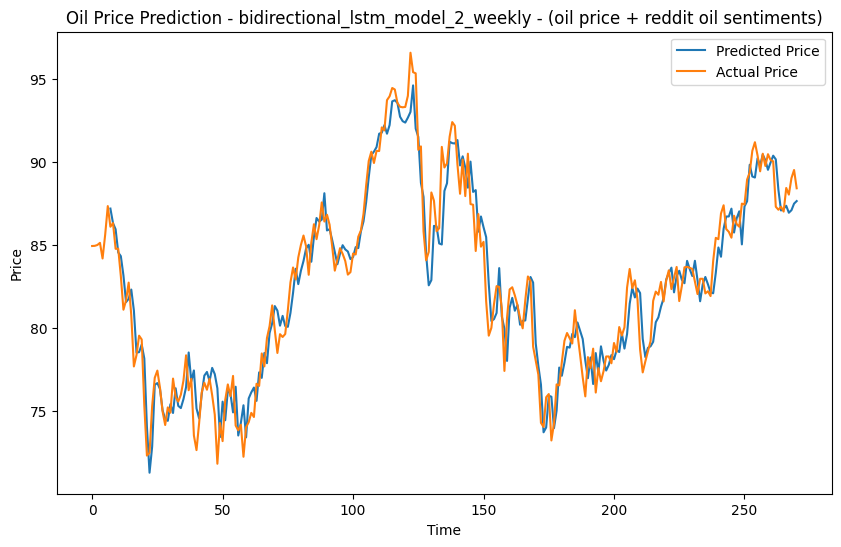

257/257 [==============================] - 3s 4ms/step


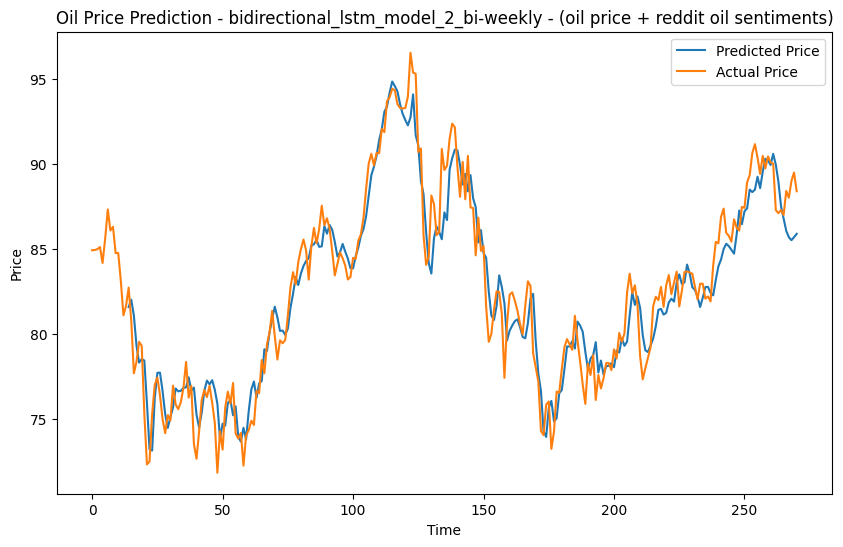

241/241 [==============================] - 3s 6ms/step


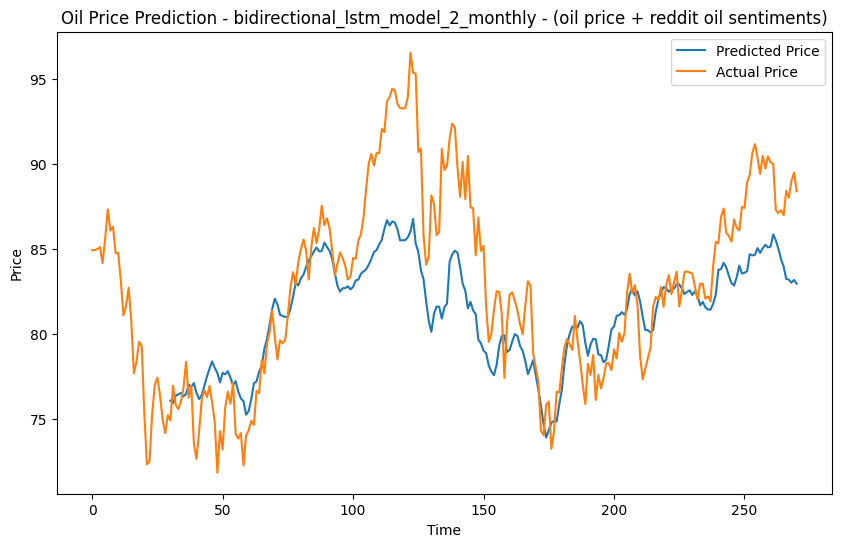

264/264 [==============================] - 4s 4ms/step


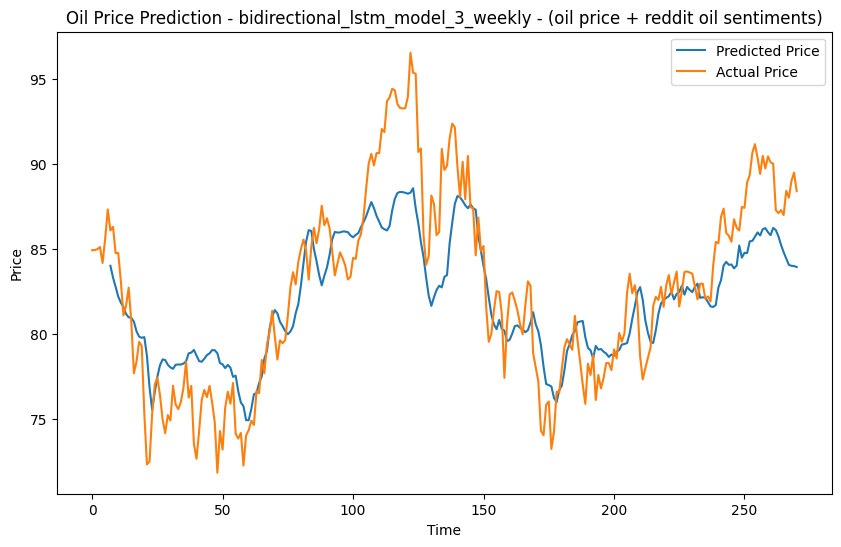

257/257 [==============================] - 4s 5ms/step


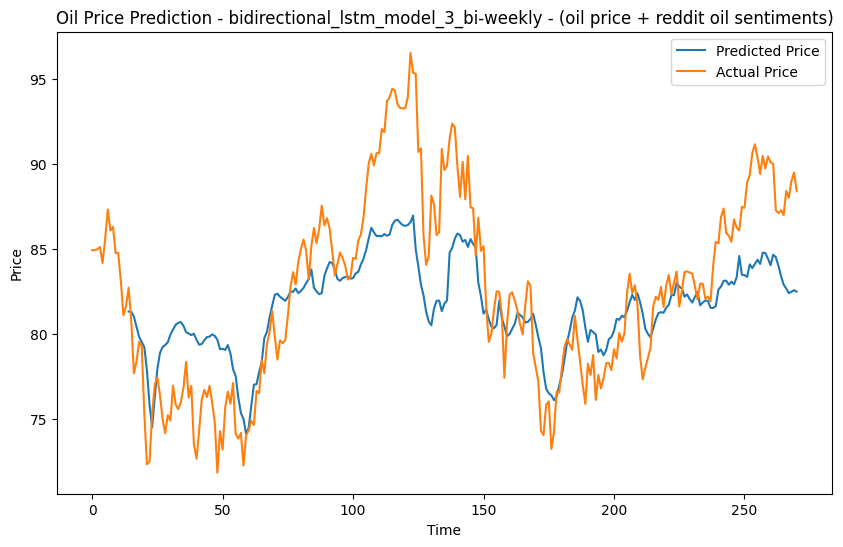

241/241 [==============================] - 4s 8ms/step


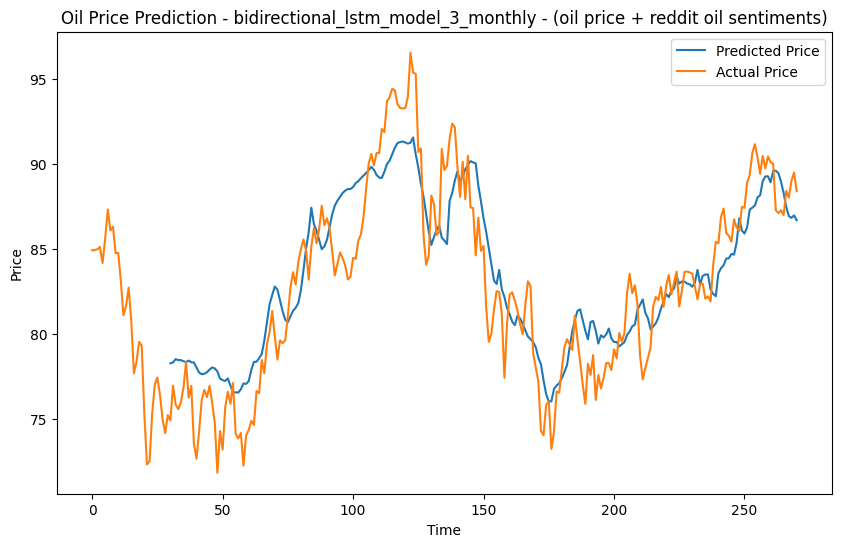

264/264 [==============================] - 3s 3ms/step


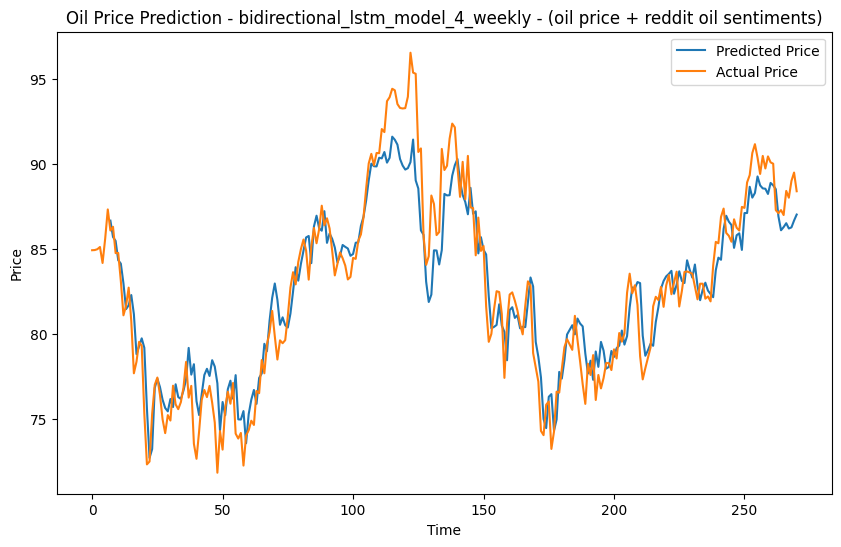

257/257 [==============================] - 3s 4ms/step


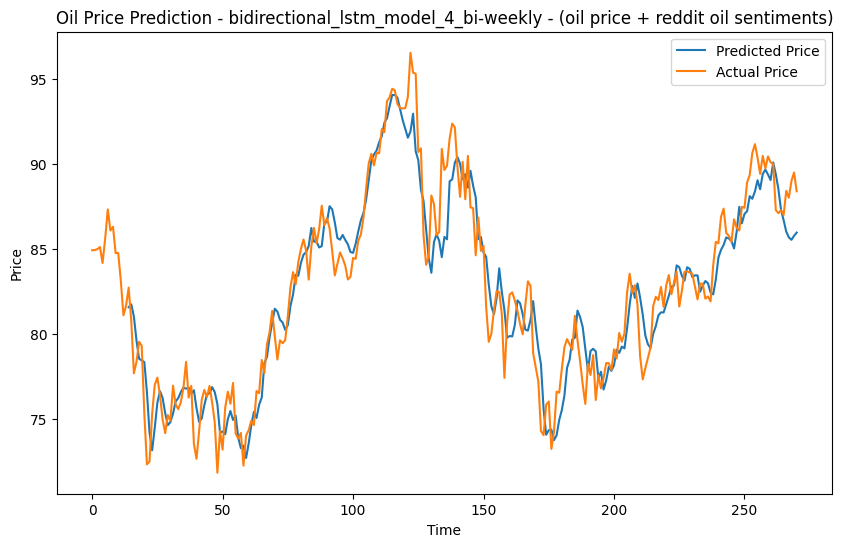

241/241 [==============================] - 3s 6ms/step


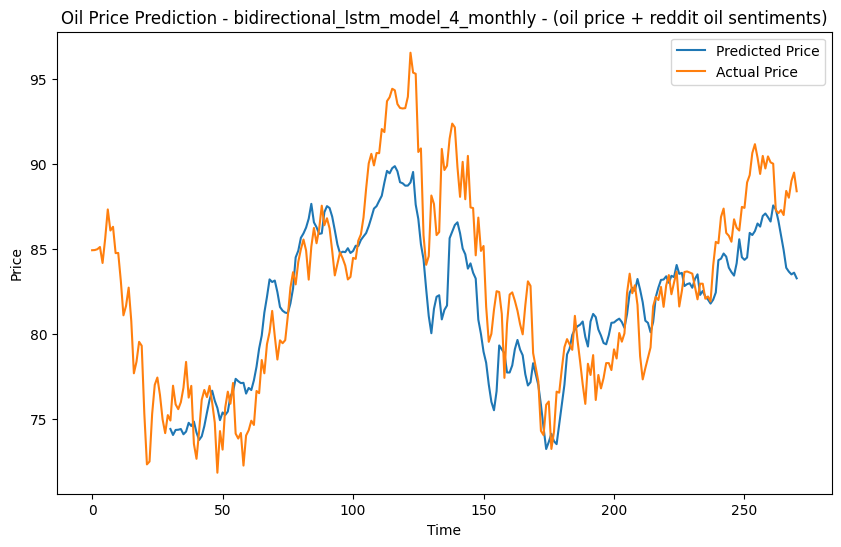

264/264 [==============================] - 3s 3ms/step


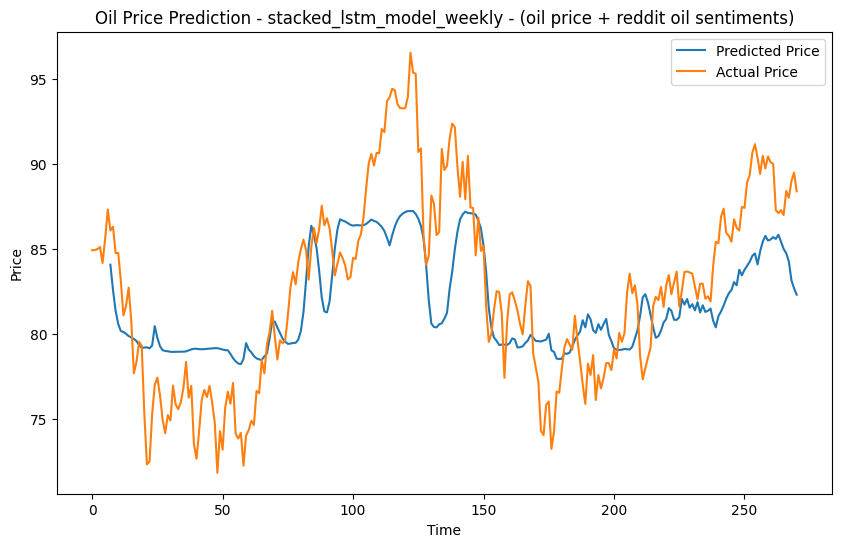

257/257 [==============================] - 3s 5ms/step


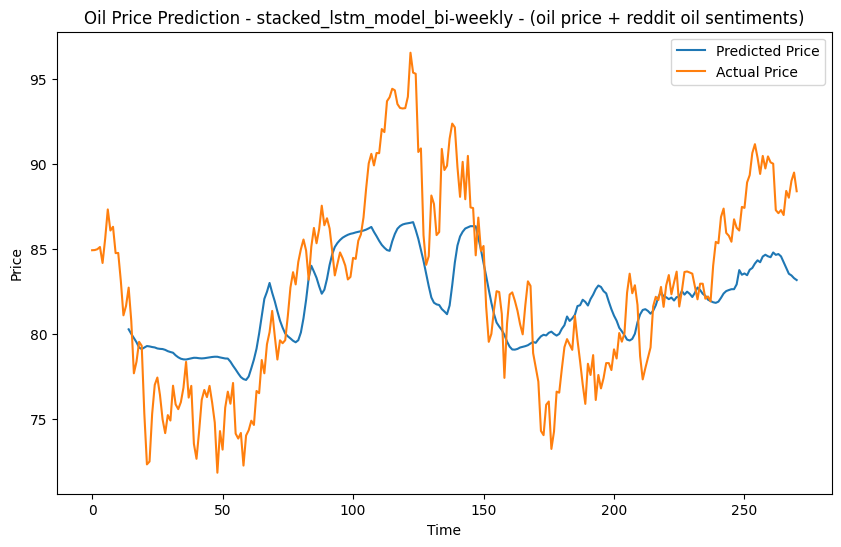

241/241 [==============================] - 3s 6ms/step


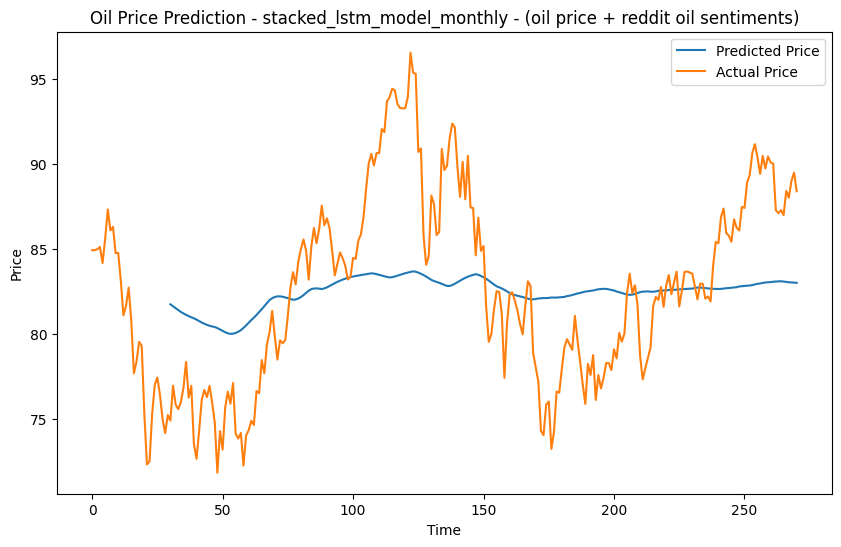

264/264 [==============================] - 1s 2ms/step
Error attention_lstm_model_weekly (264, 7, 1)
257/257 [==============================] - 2s 3ms/step
Error attention_lstm_model_bi-weekly (257, 14, 1)
241/241 [==============================] - 1s 3ms/step
Error attention_lstm_model_monthly (241, 30, 1)


In [66]:
# Plot predictions vs actual values

# Y_test = np.array([s[1][0][0][0].numpy() for s in iter(window.test)])
Y_all_data = oil_data['Price'].values
Y_all_data = scaler.inverse_transform(Y_all_data.reshape(-1, 1))

for model_name in models_list:
    model = models_list[model_name]['model']
    window = models_list[model_name]['window']
    seq_length = models_list[model_name]['seq_length']

    all_predict = model.predict(window.all_data)
    try:

        X_all_data = scaler.inverse_transform(all_predict)

        plt.figure(figsize=(10, 6))
        plt.plot(range(seq_length, seq_length + len(X_all_data)), X_all_data, label='Predicted Price')
        plt.plot(range(len(Y_all_data)), Y_all_data, label='Actual Price')
        plt.title(f'Oil Price Prediction - {model_name} - (oil price + reddit oil sentiments)')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        plt.savefig(f'outputs/oil_reddit_oil/LSTM {model_name} Oil Price Prediction.png')
        plt.show()
    except:
        print("Error", model_name, all_predict.shape)